In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('assembly_summary_genbank.txt', sep='\t', skiprows=1)
df = df[['#assembly_accession', 'taxid', 'species_taxid', 'organism_name']]

/var/folders/wx/4pnv2_1n6x7djnlzljyr7b8h0000gn/T/ipykernel_3866/3017538619.py:1: DtypeWarning: Columns (34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('assembly_summary_genbank.txt', sep='\t', skiprows=1)


In [3]:
df = pd.read_csv('assembly_summary_refseq.txt', sep='\t', skiprows=1)
df = df[['#assembly_accession', 'taxid', 'species_taxid', 'organism_name']]

/var/folders/wx/4pnv2_1n6x7djnlzljyr7b8h0000gn/T/ipykernel_3866/4130685486.py:1: DtypeWarning: Columns (34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('assembly_summary_refseq.txt', sep='\t', skiprows=1)


In [4]:
import pandas as pd
from ete3 import NCBITaxa

# Initialize NCBITaxa
ncbi = NCBITaxa()


# Define a function to get family, genus, and species names
def get_taxonomic_ranks(taxid):
    try:
        # Get the lineage of the taxid
        lineage = ncbi.get_lineage(taxid)
        # Get the names and ranks for the lineage
        names = ncbi.get_taxid_translator(lineage)
        ranks = ncbi.get_rank(lineage)
        # Extract family, genus, and species
        family = next((names[t] for t in lineage if ranks[t] == 'family'), 'unknown')
        genus = next((names[t] for t in lineage if ranks[t] == 'genus'), 'unknown')
        species = next((names[t] for t in lineage if ranks[t] == 'species'), 'unknown')
        return family, genus, species
    except Exception as e:
        #print(f"Error processing taxid {taxid}: {e}")
        return 'unknown', 'unknown', 'unknown'

# Apply the function to the 'species_taxid' column
df[['family', 'genus', 'species']] = df['taxid'].apply(
    lambda taxid: pd.Series(get_taxonomic_ranks(taxid))
)

/Users/jyshang2/miniconda3/lib/python3.11/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 2652280 was translated into 2731255
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


In [5]:
df.head()

,#assembly_accession,taxid,species_taxid,organism_name,family,genus,species
0,GCF_036600855.1,7,7,Azorhizobium caulinodans,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans
1,GCF_036600875.1,7,7,Azorhizobium caulinodans,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans
2,GCF_036600895.1,7,7,Azorhizobium caulinodans,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans
3,GCF_036600915.1,7,7,Azorhizobium caulinodans,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans
4,GCF_900128725.1,9,9,Buchnera aphidicola,Erwiniaceae,Buchnera,Buchnera aphidicola


In [6]:
df = df[(df['family'] != 'unknown') & (df['genus'] != 'unknown') & (df['species'] != 'unknown')]

In [7]:
df.to_csv('genbank_taxonomic_info.csv', index=False)

In [8]:
df.to_csv('refseq_taxonomic_info.csv', index=False)

In [9]:
df2 = pd.read_csv('genbank_taxonomic_info.csv')
df = pd.concat([df, df2], ignore_index=True)
df.drop_duplicates(subset=['#assembly_accession'], inplace=True)
df.to_csv('combined_taxonomic_info.csv', index=False)

In [10]:
p_label = pd.read_csv('ProkaryoticVirus_Species_Level_Host.csv')
p_label.head()

,Accession,Host
0,NC_092682.1,Salmonella enterica
1,NC_092683.1,Salmonella enterica
2,NC_092455.1,Klebsiella michiganensis
3,NC_092456.1,Klebsiella quasipneumoniae
4,NC_092457.1,Klebsiella variicola


In [11]:
import pandas as pd
from ete3 import NCBITaxa

# Initialize the NCBITaxa database
ncbi = NCBITaxa()
df = p_label

# Define a function to get taxonomic information
def get_taxonomy(host_name):
    try:
        # Get the taxid for the host name
        taxid = ncbi.get_name_translator([host_name])
        if not taxid:
            return {"order": 'unknown', "family": 'unknown', "genus": 'unknown', "species": 'unknown'}
        
        taxid = list(taxid.values())[0][0]
        
        # Get the lineage and ranks
        lineage = ncbi.get_lineage(taxid)
        ranks = ncbi.get_rank(lineage)
        names = ncbi.get_taxid_translator(lineage)
        
        # Extract family, genus, and species
        family = genus = species = 'unknown'
        for taxid in lineage:
            if ranks[taxid] == "family":
                family = names[taxid]
            elif ranks[taxid] == "genus":
                genus = names[taxid]
            elif ranks[taxid] == "species":
                species = names[taxid]
            elif ranks[taxid] == "order":
                order = names[taxid]
        
        return {'order':order, "family": family, "genus": genus, "species": species}
    except Exception as e:
        #print(f"Error processing host: {host_name}, Error: {e}")
        return {"order": 'unknown',"family": 'unknown', "genus": 'unknown', "species": 'unknown'}

# Apply the function to the dataframe
taxonomy_info = df["Host"].apply(get_taxonomy)

# Expand the taxonomy info into separate columns
taxonomy_df = pd.DataFrame(list(taxonomy_info))
df = pd.concat([df, taxonomy_df], axis=1)


In [12]:
df.head()

,Accession,Host,order,family,genus,species
0,NC_092682.1,Salmonella enterica,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica
1,NC_092683.1,Salmonella enterica,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella enterica
2,NC_092455.1,Klebsiella michiganensis,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella michiganensis
3,NC_092456.1,Klebsiella quasipneumoniae,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella quasipneumoniae
4,NC_092457.1,Klebsiella variicola,Enterobacterales,Enterobacteriaceae,Klebsiella,Klebsiella variicola


In [13]:
df.to_csv('virus_taxonomic_info.csv', index=False)

In [204]:
import pandas as pd

In [205]:
label = pd.read_csv('combined_taxonomic_info.csv')
label['genome'] = label['#assembly_accession'].apply(lambda x: x.split('.')[0])
genome2species = {key:item for key, item in zip(label['genome'], label['species'])}
genome2genus = {key:item for key, item in zip(label['genome'], label['genus'])}
genome2family = {key:item for key, item in zip(label['genome'], label['family'])}

In [206]:
p_label = pd.read_csv('virus_taxonomic_info.csv')
p_genome2species = {key:item for key, item in zip(p_label['Accession'], p_label['species'])}
p_genome2genus = {key:item for key, item in zip(p_label['Accession'], p_label['genus'])}
p_genome2family = {key:item for key, item in zip(p_label['Accession'], p_label['family'])}

In [207]:
crispr = pd.read_csv('crispr.csv')
crispr.head()

,qseqid,sseqid,evalue,pident,length,slen,cov
0,NC_092681.1,GCF_002165255_CRISPR_172,0.390,90.909,33,32,1.031250
1,NC_092681.1,GCF_002165255_CRISPR_172,0.390,90.909,33,32,1.031250
2,NC_092681.1,GCA_002165255_CRISPR_172,0.390,90.909,33,32,1.031250
3,NC_092681.1,GCA_002165255_CRISPR_172,0.390,90.909,33,32,1.031250
4,NC_092683.1,GCA_951828385_CRISPR_222,0.002,91.176,34,37,0.918919


In [208]:
crispr['qgenome'] = crispr['qseqid']
crispr['sgenome'] = crispr['sseqid'].apply(lambda x: x.split('_CRISPR_')[0])
crispr['qspecies'] = crispr['qgenome'].apply(lambda x: p_genome2species.get(x), 'Unknown')
crispr['sspecies'] = crispr['sgenome'].apply(lambda x: genome2species.get(x), 'Unknown')
crispr['qgenus'] = crispr['qgenome'].apply(lambda x: p_genome2genus.get(x, 'Unknown'))
crispr['sgenus'] = crispr['sgenome'].apply(lambda x: genome2genus.get(x, 'Unknown'))
crispr['qfamily'] = crispr['qgenome'].apply(lambda x: p_genome2family.get(x, 'Unknown'))
crispr['sfamily'] = crispr['sgenome'].apply(lambda x: genome2family.get(x, 'Unknown'))
crispr = crispr[crispr['sgenus'] != 'Unknown']
crispr['cov'] = crispr['length'] / crispr['slen']*100

/var/folders/wx/4pnv2_1n6x7djnlzljyr7b8h0000gn/T/ipykernel_3866/1438393309.py:3: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  crispr['qspecies'] = crispr['qgenome'].apply(lambda x: p_genome2species.get(x), 'Unknown')
/var/folders/wx/4pnv2_1n6x7djnlzljyr7b8h0000gn/T/ipykernel_3866/1438393309.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  crispr['sspecies'] = crispr['sgenome'].apply(lambda x: genome2species.get(x), 'Unknown')


In [209]:
crispr = crispr[(crispr['qspecies'] != 'Unknown')& (crispr['sspecies'] != 'Unknown')& (crispr['qgenus'] != 'Unknown') & (crispr['sgenus'] != 'Unknown')]
crispr.head()

,qseqid,sseqid,evalue,pident,length,slen,cov,qgenome,sgenome,qspecies,sspecies,qgenus,sgenus,qfamily,sfamily
5,NC_092683.1,GCF_003992745_CRISPR_65,0.10000,90.323,31,33,93.939394,NC_092683.1,GCF_003992745,Salmonella enterica,Pectobacterium parmentieri,Salmonella,Pectobacterium,Enterobacteriaceae,Pectobacteriaceae
7,NC_092683.1,GCF_001742145_CRISPR_23,0.10000,90.323,31,33,93.939394,NC_092683.1,GCF_001742145,Salmonella enterica,Pectobacterium parmentieri,Salmonella,Pectobacterium,Enterobacteriaceae,Pectobacteriaceae
10,NC_092683.1,GCF_003628575_CRISPR_65,0.10000,90.323,31,33,93.939394,NC_092683.1,GCF_003628575,Salmonella enterica,Pectobacterium parmentieri,Salmonella,Pectobacterium,Enterobacteriaceae,Pectobacteriaceae
11,NC_092455.1,GCF_000234745_CRISPR_86,0.04900,90.323,31,32,96.875000,NC_092455.1,GCF_000234745,Klebsiella michiganensis,Pasteurella multocida,Klebsiella,Pasteurella,Enterobacteriaceae,Pasteurellaceae
13,NC_079174.1,GCF_001277195_CRISPR_61,0.00001,96.970,33,33,100.000000,NC_079174.1,GCF_001277195,Erwinia amylovora,Cronobacter muytjensii,Erwinia,Cronobacter,Erwiniaceae,Enterobacteriaceae


In [210]:
len(crispr['qseqid'].unique())

3145

In [117]:
# best hit
data = []
data2 = []
data3 = []
for cov in range(90, 101, 1):
    for pident in range(90, 101, 1):
        df_500 = crispr[crispr['cov'] >= cov]
        df_500 = df_500[df_500['pident'] >= pident]
        species_correct = 0
        genus_correct = 0
        family_correct = 0
        for idx, group in df_500.groupby('qseqid'):
            slabel = group['qspecies'].iloc[0]
            glabel = group['qgenus'].iloc[0]
            flabel = group['qfamily'].iloc[0]

            if slabel == group['sspecies'].values[0]:
                species_correct += 1
            
            if glabel == group['sgenus'].values[0]:
                genus_correct += 1
            
            if flabel == group['sfamily'].values[0]:
                family_correct += 1

        data.append([pident, cov, 'species', species_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'genus', genus_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'family', family_correct/df_500['qseqid'].nunique()])
        data3.append([pident, cov, 'species', df_500['qseqid'].nunique()/4698])
        data3.append([pident, cov, 'genus', df_500['qseqid'].nunique()/4698])
        data3.append([pident, cov, 'family', df_500['qseqid'].nunique()/4698])


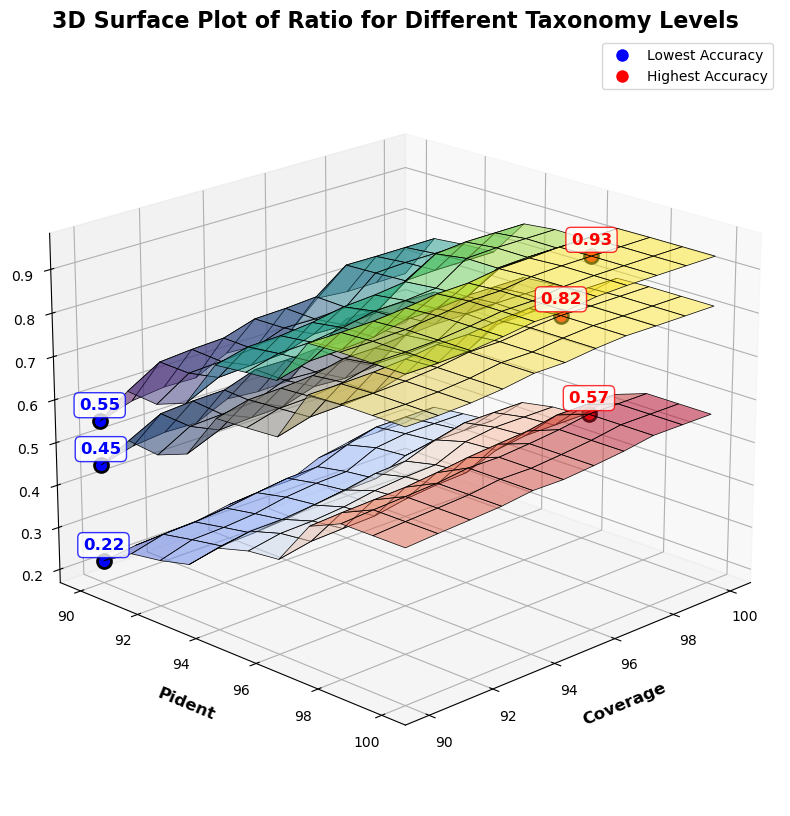

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'coverage', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.5, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis

# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('CRISPR_accuracy_best_hit.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('CRISPR_accuracy_best_hit.csv', index=False)

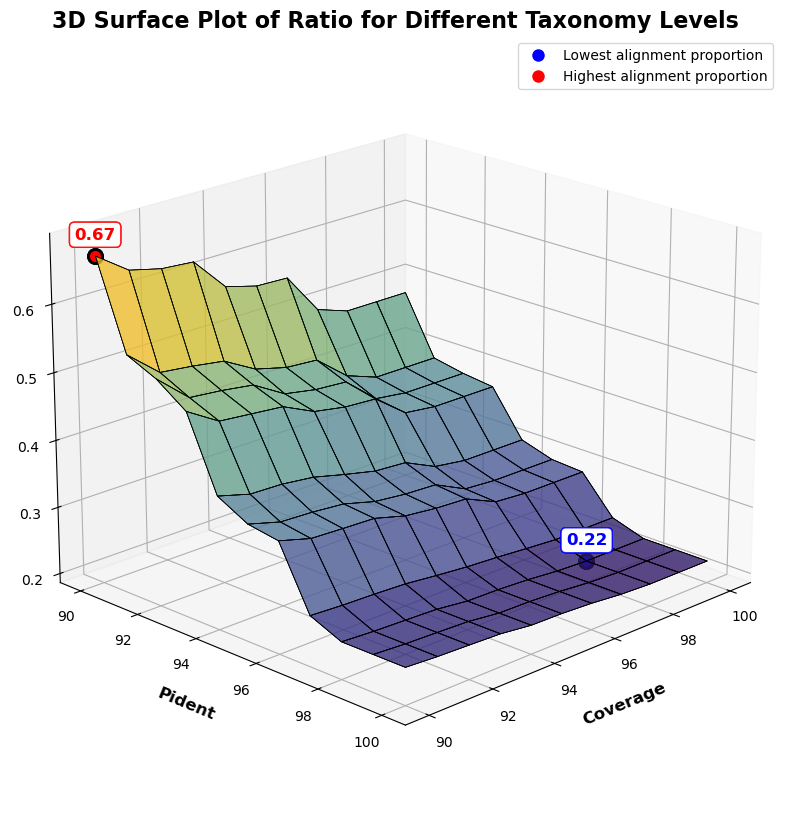

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data3, columns=['pident', 'coverage', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))
# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis
# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest alignment proportion'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest alignment proportion')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('CRISPR_alignment_proportion.png', dpi=300, bbox_inches='tight')
plt.show()
df.rename(columns={'ratio': 'alignment_proportion'}, inplace=True)
df.to_csv('CRISPR_alignment_proportion.csv', index=False)

In [120]:
data = []
data2 = []
for cov in range(90, 101, 1):
    for pident in range(90, 101, 1):
        df_500 = crispr[crispr['cov'] >= cov]
        df_500 = df_500[df_500['pident'] >= pident]
        species_correct = 0
        species_pred = 0
        genus_correct = 0
        genus_pred = 0
        family_correct = 0
        family_pred = 0
        for idx, group in df_500.groupby('qseqid'):
            slabel = group['qspecies'].iloc[0]
            glabel = group['qgenus'].iloc[0]
            flabel = group['qfamily'].iloc[0]

            species_pred += len(group['sspecies'].unique())
            if slabel in group['sspecies'].values:
                species_correct += 1
            
            genus_pred += len(group['sgenus'].unique())
            if glabel in group['sgenus'].values:
                genus_correct += 1
            
            family_pred += len(group['sfamily'].unique())
            if flabel in group['sfamily'].values:
                family_correct += 1

        data.append([pident, cov, 'species', species_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'genus', genus_correct/df_500['qseqid'].nunique()])
        data.append([pident, cov, 'family', family_correct/df_500['qseqid'].nunique()])
        data2.append([pident, cov, 'species', species_correct/species_pred])
        data2.append([pident, cov, 'genus', genus_correct/genus_pred])
        data2.append([pident, cov, 'family', family_correct/family_pred])
        #print("Species level: ", species_correct, species_pred, species_correct/species_pred, species_correct/df_500['qseqid'].nunique())
        #print("Genus level: ", genus_correct, genus_pred, genus_correct/genus_pred, genus_correct/df_500['qseqid'].nunique())
        #print("Family level: ", family_correct, family_pred, family_correct/family_pred, family_correct/df_500['qseqid'].nunique())
        #print("Prediction rate: ", df_500['qseqid'].nunique()/19974)

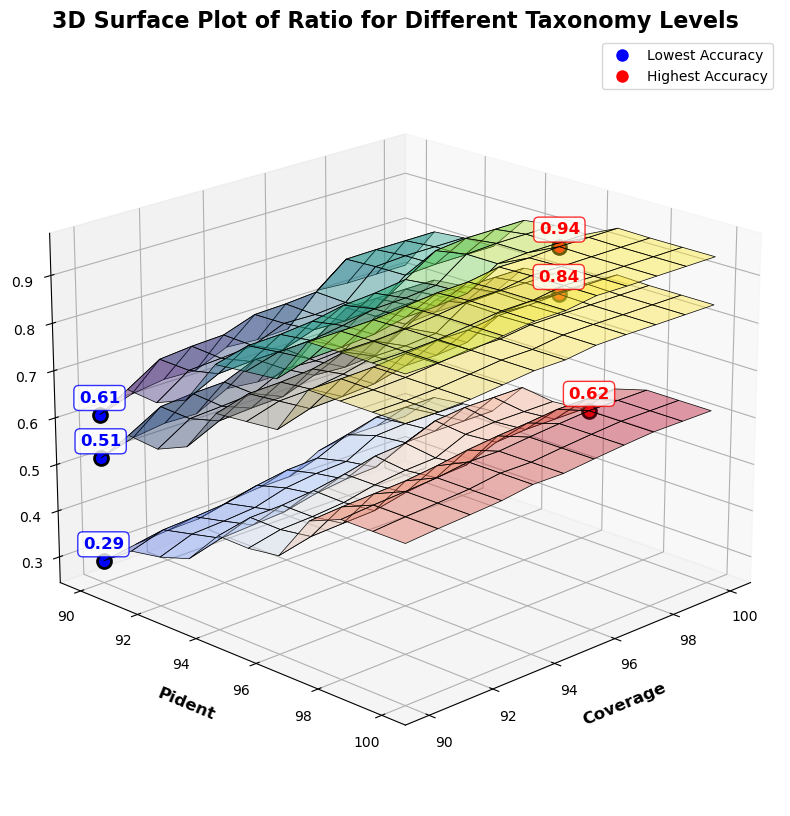

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'coverage', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis
# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('CRISPR_accuracy_all.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('CRISPR_accuracy_all.csv', index=False)

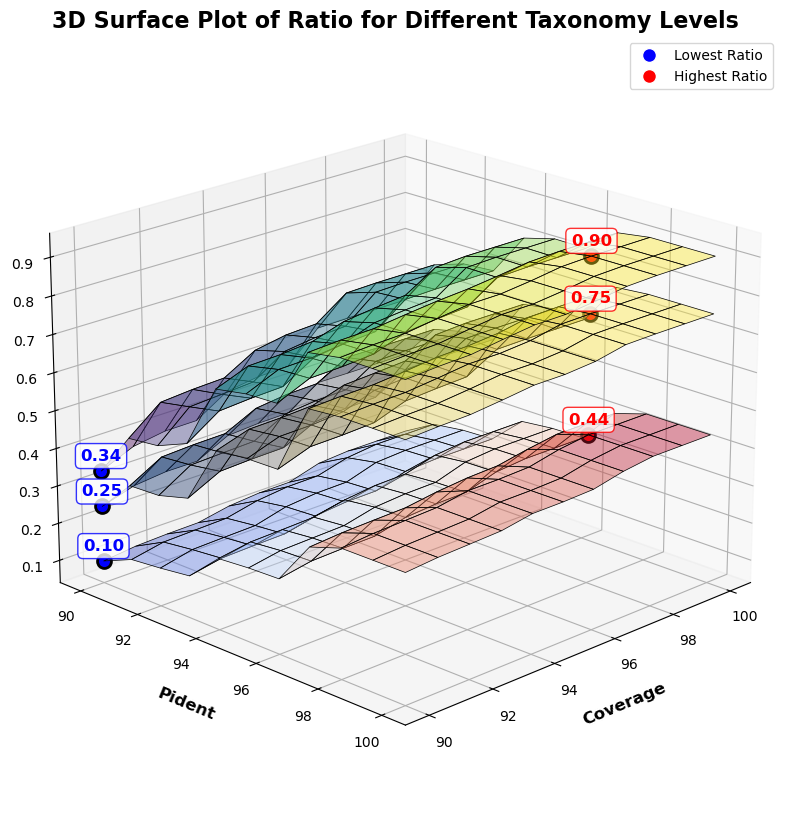

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data2, columns=['pident', 'coverage', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='coverage', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['coverage'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['coverage'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['coverage'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['coverage'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Reverse the Length axis
ax.set_xlim(ax.get_xlim()[::-1])  # Add this line to reverse the Length axis

# Set labels and title for the combined plot
ax.set_xlabel('Coverage', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Ratio'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Ratio')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('CRISPR_accuracy_ratio.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('CRISPR_accuracy_ratio.csv', index=False)

In [193]:
df = pd.read_csv('BLASTN.csv')
df.head()

,qseqid,sseqid,evalue,pident,length,genome
0,NC_070911.1,ref|NZ_CP103679.1|,1.840000e-35,94.000,100,GCF_024918215
1,NC_071003.1,ref|NZ_CP103679.1|,0.000000e+00,90.020,2475,GCF_024918215
2,NC_071003.1,ref|NZ_CP103679.1|,0.000000e+00,90.357,2437,GCF_024918215
3,NC_071003.1,ref|NZ_CP103679.1|,0.000000e+00,90.357,2437,GCF_024918215
4,NC_071003.1,ref|NZ_CP103679.1|,0.000000e+00,91.882,1663,GCF_024918215


In [194]:
df = df.drop(columns=['sseqid', 'evalue'])

In [195]:
df['qspecies'] = df['qseqid'].apply(lambda x: p_genome2species.get(x, 'Unknown'))
df['sspecies'] = df['genome'].apply(lambda x: genome2species.get(x, 'Unknown'))
df['qgenus'] = df['qseqid'].apply(lambda x: p_genome2genus.get(x, 'Unknown'))
df['sgenus'] = df['genome'].apply(lambda x: genome2genus.get(x, 'Unknown'))
df['qfamily'] = df['qseqid'].apply(lambda x: p_genome2family.get(x, 'Unknown'))
df['sfamily'] = df['genome'].apply(lambda x: genome2family.get(x, 'Unknown'))

In [196]:
df = df[(df['qspecies'] != 'Unknown') & (df['sspecies'] != 'Unknown') &
        (df['qgenus'] != 'Unknown') & (df['sgenus'] != 'Unknown') &
        (df['qfamily'] != 'Unknown') & (df['sfamily'] != 'Unknown')]

In [197]:
df['qseqid'].nunique()

2078

In [198]:
df.head()

,qseqid,pident,length,genome,qspecies,sspecies,qgenus,sgenus,qfamily,sfamily
0,NC_070911.1,94.000,100,GCF_024918215,Salmonella enterica,Enterobacter hormaechei,Salmonella,Enterobacter,Enterobacteriaceae,Enterobacteriaceae
1,NC_071003.1,90.020,2475,GCF_024918215,Enterobacter cloacae,Enterobacter hormaechei,Enterobacter,Enterobacter,Enterobacteriaceae,Enterobacteriaceae
2,NC_071003.1,90.357,2437,GCF_024918215,Enterobacter cloacae,Enterobacter hormaechei,Enterobacter,Enterobacter,Enterobacteriaceae,Enterobacteriaceae
3,NC_071003.1,90.357,2437,GCF_024918215,Enterobacter cloacae,Enterobacter hormaechei,Enterobacter,Enterobacter,Enterobacteriaceae,Enterobacteriaceae
4,NC_071003.1,91.882,1663,GCF_024918215,Enterobacter cloacae,Enterobacter hormaechei,Enterobacter,Enterobacter,Enterobacteriaceae,Enterobacteriaceae


In [199]:
df.drop_duplicates(subset=['qseqid', 'genome'], inplace=True)

In [200]:
df.shape

(1358879, 10)

In [41]:
from tqdm import tqdm

In [73]:
data = []
data3 = []
with tqdm(total=100) as pbar:
    for length in range(100, 1050, 100):
        for pident in range(90, 101, 1):
            df_500 = df[df['length'] >= length]
            df_500 = df_500[df_500['pident'] >= pident]
            species_correct = 0
            species_pred = 0
            genus_correct = 0
            genus_pred = 0
            family_correct = 0
            family_pred = 0
            for idx, group in df_500.groupby('qseqid'):
                slabel = group['qspecies'].iloc[0]
                glabel = group['qgenus'].iloc[0]
                flabel = group['qfamily'].iloc[0]

                if slabel == group['sspecies'].values[0]:
                    species_correct += 1
                
                if glabel == group['sgenus'].values[0]:
                    genus_correct += 1
                
                if flabel == group['sfamily'].values[0]:
                    family_correct += 1

            data.append([pident, length, 'species', species_correct/df_500['qseqid'].nunique()])
            data.append([pident, length, 'genus', genus_correct/df_500['qseqid'].nunique()])
            data.append([pident, length, 'family', family_correct/df_500['qseqid'].nunique()])

            data3.append([pident, length, 'species', df_500['qseqid'].nunique()/4698])
            data3.append([pident, length, 'genus', df_500['qseqid'].nunique()/4698])
            data3.append([pident, length, 'family', df_500['qseqid'].nunique()/4698])
            _ = pbar.update(1)
        #data2.append([pident, length, 'species', species_correct/species_pred])
        #data2.append([pident, length, 'genus', genus_correct/genus_pred])
        #data2.append([pident, length, 'family', family_correct/family_pred])
        #print(f"Threshold {length}")
        #print("Species level: ", species_correct, species_pred, species_correct/species_pred, species_correct/df_500['qseqid'].nunique())
        #print("Genus level: ", genus_correct, genus_pred, genus_correct/genus_pred, genus_correct/df_500['qseqid'].nunique())
        #print("Family level: ", family_correct, family_pred, family_correct/family_pred, family_correct/df_500['qseqid'].nunique())
        #print("Prediction rate: ", df_500['qseqid'].nunique()/19974)

110it [00:33,  3.29it/s]                         


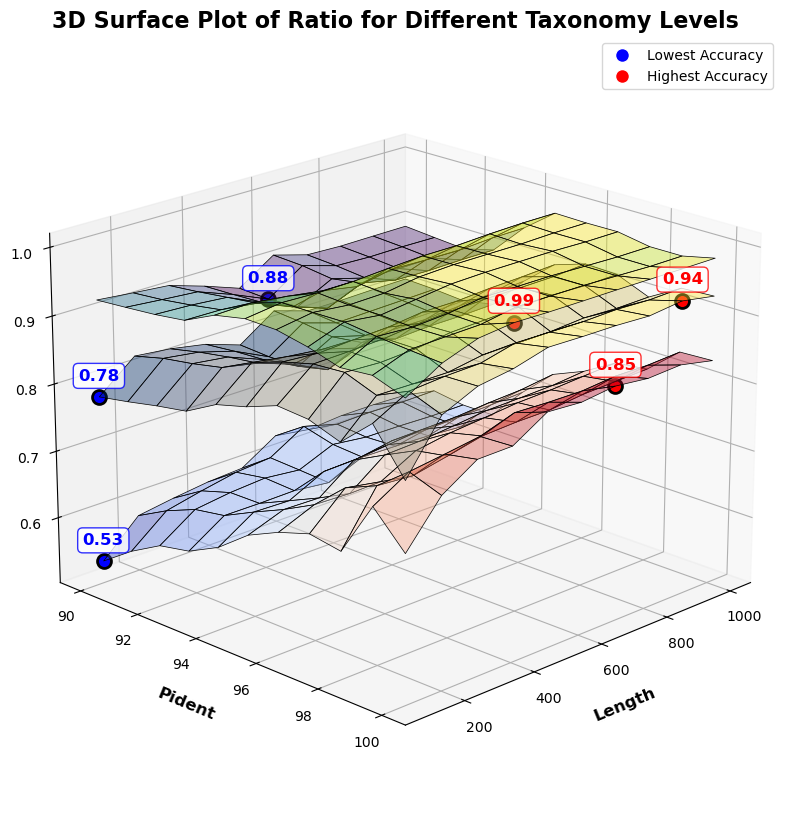

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'length', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='length', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['length'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['length'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['length'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['length'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Set labels and title for the combined plot
ax.set_xlabel('Length', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Reverse the length axis
ax.set_xlim(ax.get_xlim()[::-1])

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('BLASTN_accuracy_best_hit.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('BLASTN_accuracy_best_hit.csv', index=False)

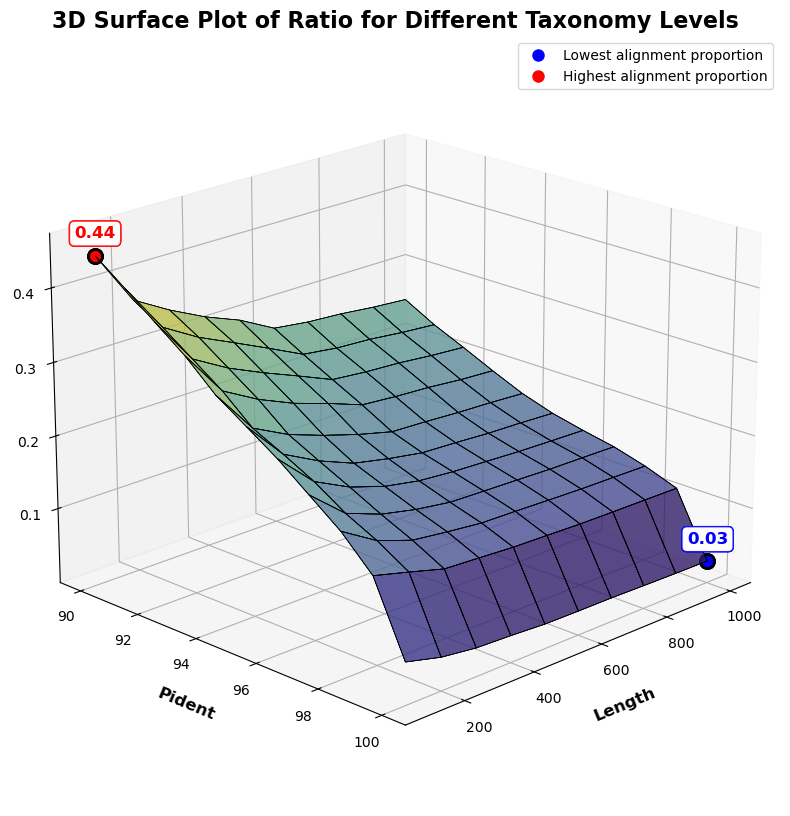

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data3, columns=['pident', 'length', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='length', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['length'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['length'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['length'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['length'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Set labels and title for the combined plot
ax.set_xlabel('Length', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Reverse the length axis
ax.set_xlim(ax.get_xlim()[::-1])

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest alignment proportion'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest alignment proportion')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('BLASTN_alignment_proportion.png', dpi=300, bbox_inches='tight')
plt.show()
df.rename(columns={'ratio': 'alignment_proportion'}, inplace=True)
df.to_csv('BLASTN_alignment_proportion.csv', index=False)

In [ ]:
data = []
data2 = []
for length in range(100, 1050, 100):
    for pident in range(90, 101, 1):
        df_500 = df[df['length'] >= length]
        df_500 = df_500[df_500['pident'] >= pident]
        species_correct = 0
        species_pred = 0
        genus_correct = 0
        genus_pred = 0
        family_correct = 0
        family_pred = 0
        for idx, group in df_500.groupby('qseqid'):
            slabel = group['qspecies'].iloc[0]
            glabel = group['qgenus'].iloc[0]
            flabel = group['qfamily'].iloc[0]

            species_pred += len(group['sspecies'].unique())
            if slabel in group['sspecies'].values:
                species_correct += 1
            
            genus_pred += len(group['sgenus'].unique())
            if glabel in group['sgenus'].values:
                genus_correct += 1
            
            family_pred += len(group['sfamily'].unique())
            if flabel in group['sfamily'].values:
                family_correct += 1

        data.append([pident, length, 'species', species_correct/df_500['qseqid'].nunique()])
        data.append([pident, length, 'genus', genus_correct/df_500['qseqid'].nunique()])
        data.append([pident, length, 'family', family_correct/df_500['qseqid'].nunique()])
        data2.append([pident, length, 'species', species_correct/species_pred])
        data2.append([pident, length, 'genus', genus_correct/genus_pred])
        data2.append([pident, length, 'family', family_correct/family_pred])
        #print(f"Threshold {length}")
        #print("Species level: ", species_correct, species_pred, species_correct/species_pred, species_correct/df_500['qseqid'].nunique())
        #print("Genus level: ", genus_correct, genus_pred, genus_correct/genus_pred, genus_correct/df_500['qseqid'].nunique())
        #print("Family level: ", family_correct, family_pred, family_correct/family_pred, family_correct/df_500['qseqid'].nunique())
        #print("Prediction rate: ", df_500['qseqid'].nunique()/19974)

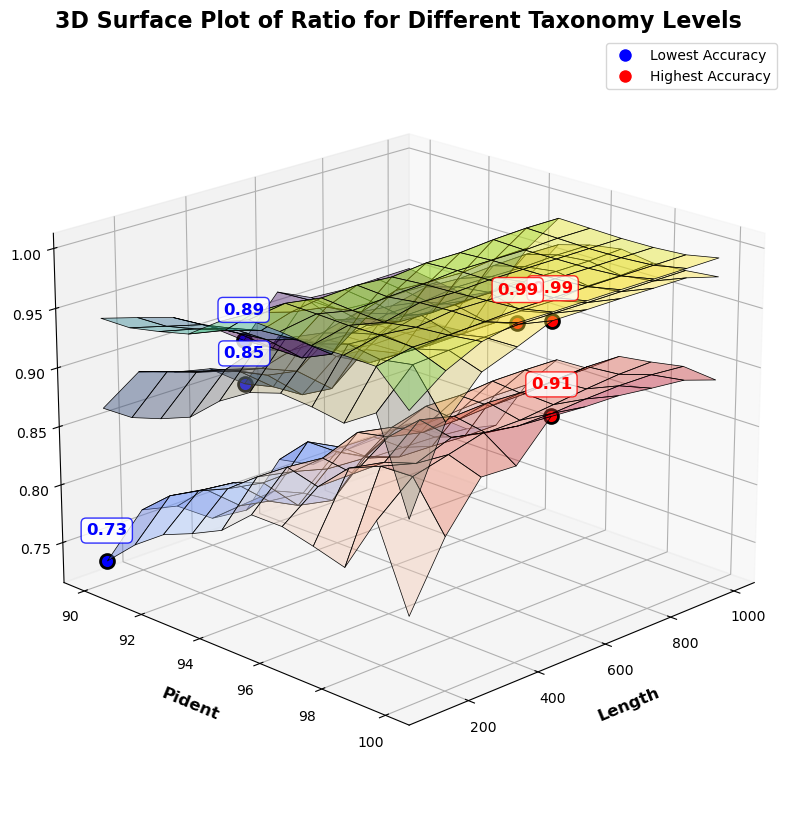

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data, columns=['pident', 'length', 'taxonomy', 'accuracy'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['accuracy'].idxmin()]
    max_row = df_level.loc[df_level['accuracy'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='length', values='accuracy')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['length'], min_row['pident'], min_row['accuracy'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['length'], max_row['pident'], max_row['accuracy'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['length'], min_row['pident'], min_row['accuracy'] + 0.02, 
            f"{min_row['accuracy']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['length'], max_row['pident'], max_row['accuracy'] + 0.02, 
            f"{max_row['accuracy']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Set labels and title for the combined plot
ax.set_xlabel('Length', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Accuracy', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')


# Reverse the length axis
ax.set_xlim(ax.get_xlim()[::-1])

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Accuracy'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Accuracy')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('BLASTN_accuracy_all.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('BLASTN_accuracy_all.csv', index=False)

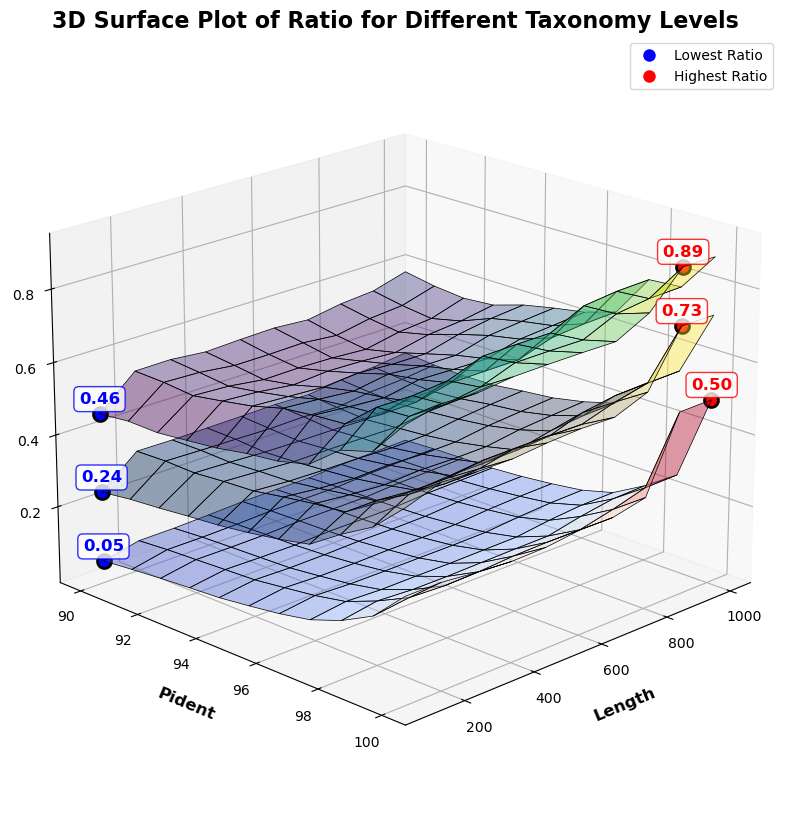

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Sample Data Generation ---
# Assuming 'data' is already defined and structured appropriately
taxonomy_levels = ['species', 'genus', 'family']
df = pd.DataFrame(data2, columns=['pident', 'length', 'taxonomy', 'ratio'])

# --- 2. Combined 3D Surface Plot ---
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')

# Define a colormap for different taxonomy levels
colors = {'species': 'coolwarm', 'genus': 'cividis', 'family': 'viridis'}

# Store all min/max points to plot them after all surfaces
all_points = []

# Loop through each taxonomy level and plot surfaces
for i, level in enumerate(taxonomy_levels):
    # Filter the data for the current taxonomy level
    df_level = df[df['taxonomy'] == level]
    
    # Find min and max accuracy points
    min_row = df_level.loc[df_level['ratio'].idxmin()]
    max_row = df_level.loc[df_level['ratio'].idxmax()]
    
    # Store points for later plotting
    all_points.append({
        'level': level,
        'min_row': min_row,
        'max_row': max_row
    })
    
    # Pivot the data to create a grid for the surface plot
    pivot_df = df_level.pivot(index='pident', columns='length', values='ratio')
    
    # Create the meshgrid for the X and Y coordinates
    X, Y = np.meshgrid(pivot_df.columns, pivot_df.index)
    Z = pivot_df.values
    
    # Plot the surface with transparency
    surf = ax.plot_surface(X, Y, Z, cmap=colors[level], edgecolor='k', 
                          linewidth=0.5, alpha=0.4, antialiased=True, 
                          shade=True, zorder=1)

# Plot all scatter points and annotations AFTER all surfaces
for point_data in all_points:
    level = point_data['level']
    min_row = point_data['min_row']
    max_row = point_data['max_row']
    
    # Add scatter points with higher zorder
    ax.scatter(min_row['length'], min_row['pident'], min_row['ratio'], 
               color='blue', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    ax.scatter(max_row['length'], max_row['pident'], max_row['ratio'], 
               color='red', s=100, edgecolor='black', linewidth=2, 
               depthshade=False, zorder=10)
    
    # Add annotations with offset to avoid overlap with points
    # For minimum point
    ax.text(min_row['length'], min_row['pident'], min_row['ratio'] + 0.02, 
            f"{min_row['ratio']:.2f}", color='blue', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='blue', alpha=0.8))
    
    # For maximum point
    ax.text(max_row['length'], max_row['pident'], max_row['ratio'] + 0.02, 
            f"{max_row['ratio']:.2f}", color='red', fontsize=12, 
            weight='bold', ha='center', va='bottom', zorder=11,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                     edgecolor='red', alpha=0.8))

# Set labels and title for the combined plot
ax.set_xlabel('Length', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Pident', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Ratio', fontsize=12, fontweight='bold', labelpad=10, rotation=90)
ax.set_title('3D Surface Plot of Ratio for Different Taxonomy Levels', fontsize=16, fontweight='bold')

# Reverse the length axis
ax.set_xlim(ax.get_xlim()[::-1])

# Customize ticks and grid
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)

# Add a legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', 
               markersize=10, label='Lowest Ratio'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', 
               markersize=10, label='Highest Ratio')
]

ax.legend(handles=handles, loc='best', fontsize=10)

# Save the figure as a high-resolution image
plt.savefig('BLASTN_accuracy_ratio.png', dpi=300, bbox_inches='tight')
plt.show()
df.to_csv('BLASTN_accuracy_ratio.csv', index=False)

# consistency

In [212]:
df.shape

(1358879, 10)

In [211]:
crispr.shape

(42374, 15)

In [213]:
crispr_species = crispr[crispr['cov'] >= 98]
crispr_species = crispr_species[crispr_species['pident'] >= 98]
crispr_species.drop_duplicates(subset=['qseqid'], inplace=True)
crispr_species = crispr_species[crispr_species['qspecies'] == crispr_species['sspecies']]
crispr_species.shape

(583, 15)

In [201]:
df_species = df[df['length'] >= 700]
df_species = df_species[df_species['pident'] >= 100]
df_species.drop_duplicates(subset=['qseqid'], inplace=True)
df_species = df_species[df_species['qspecies'] == df_species['sspecies']]
df_species.shape

(117, 10)

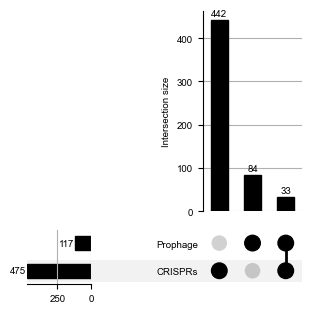

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_species['qseqid']) - set(df_species['qseqid'])),
        len(set(df_species['qseqid']) - set(crispr_species['qseqid'])),
        len(set(crispr_species['qseqid']) & set(df_species['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_species.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [215]:
crispr_genus = crispr[crispr['cov'] >= 98]
crispr_genus = crispr_genus[crispr_genus['pident'] >= 98]
crispr_genus.drop_duplicates(subset=['qseqid'], inplace=True)
crispr_genus = crispr_genus[crispr_genus['qgenus'] == crispr_genus['sgenus']]
crispr_genus.shape

(840, 15)

In [216]:
df_genus = df[df['length'] >= 700]
df_genus = df_genus[df_genus['pident'] >= 100]
df_genus.drop_duplicates(subset=['qseqid'], inplace=True)
df_genus = df_genus[df_genus['qgenus'] == df_genus['sgenus']]
df_genus.shape

(129, 10)

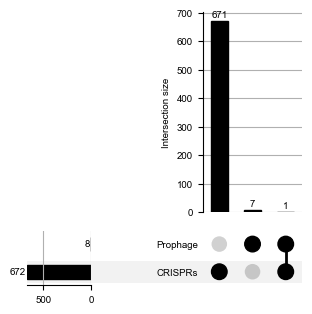

In [184]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_genus['qseqid']) - set(df_genus['qseqid'])),
        len(set(df_genus['qseqid']) - set(crispr_genus['qseqid'])),
        len(set(crispr_genus['qseqid']) & set(df_genus['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_genus.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [217]:
crispr_family = crispr[crispr['cov'] >= 98]
crispr_family = crispr_family[crispr_family['pident'] >= 98]
crispr_family.drop_duplicates(subset=['qseqid'], inplace=True)
crispr_family = crispr_family[crispr_family['qfamily'] == crispr_family['sfamily']]
crispr_family.shape

(957, 15)

In [218]:
df_family = df[df['length'] >= 700]
df_family = df_family[df_family['pident'] >= 100]
df_family.drop_duplicates(subset=['qseqid'], inplace=True)
df_family = df_family[df_family['qfamily'] == df_family['sfamily']]
df_family.shape

(136, 10)

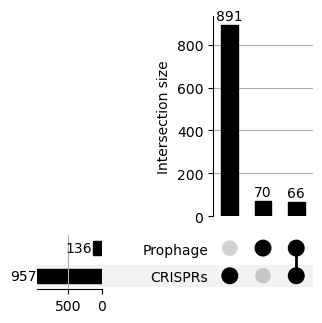

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from upsetplot import from_memberships
from upsetplot import plot


# Prepare data for UpSet plot
example = from_memberships(
    [
        ['CRISPRs'],
        ['Prophage'],
        ['CRISPRs', 'Prophage']
    ],
    data=[
        len(set(crispr_family['qseqid']) - set(df_family['qseqid'])),
        len(set(df_family['qseqid']) - set(crispr_family['qseqid'])),
        len(set(crispr_family['qseqid']) & set(df_family['qseqid']))
    ]
)

# Plot the UpSet plot
plot(example, show_counts=True)

# Save the plot as a PDF
plt.savefig("upset_plot_family.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

In [ ]:
crispr.drop_duplicates(subset=['qseqid'], inplace=True)
crispr_remain = crispr[crispr['qseqid'].isin(df['qseqid'])]

In [ ]:
df.drop_duplicates(subset=['qseqid'], inplace=True)
df_remain = df[df['qseqid'].isin(crispr['qseqid'])]

In [153]:
crispr2species = {key: value for key, value in zip(crispr_remain['qseqid'], crispr_remain['sspecies'])}
crispr2genus = {key: value for key, value in zip(crispr_remain['qseqid'], crispr_remain['sgenus'])}
crispr2family = {key: value for key, value in zip(crispr_remain['qseqid'], crispr_remain['sfamily'])}
df2species = {key: value for key, value in zip(df_remain['qseqid'], df_remain['sspecies'])}
df2genus = {key: value for key, value in zip(df_remain['qseqid'], df_remain['sgenus'])}
df2family = {key: value for key, value in zip(df_remain['qseqid'], df_remain['sfamily'])}

In [173]:
common = 0
inconsist = 0
for key in crispr2species.keys():
    if key in df2species:
        if crispr2species[key] == df2species[key]:
            common += 1
        else:
            inconsist += 1
print(f"Common species: {common}, Inconsistent species: {inconsist}")

Common species: 520, Inconsistent species: 1196


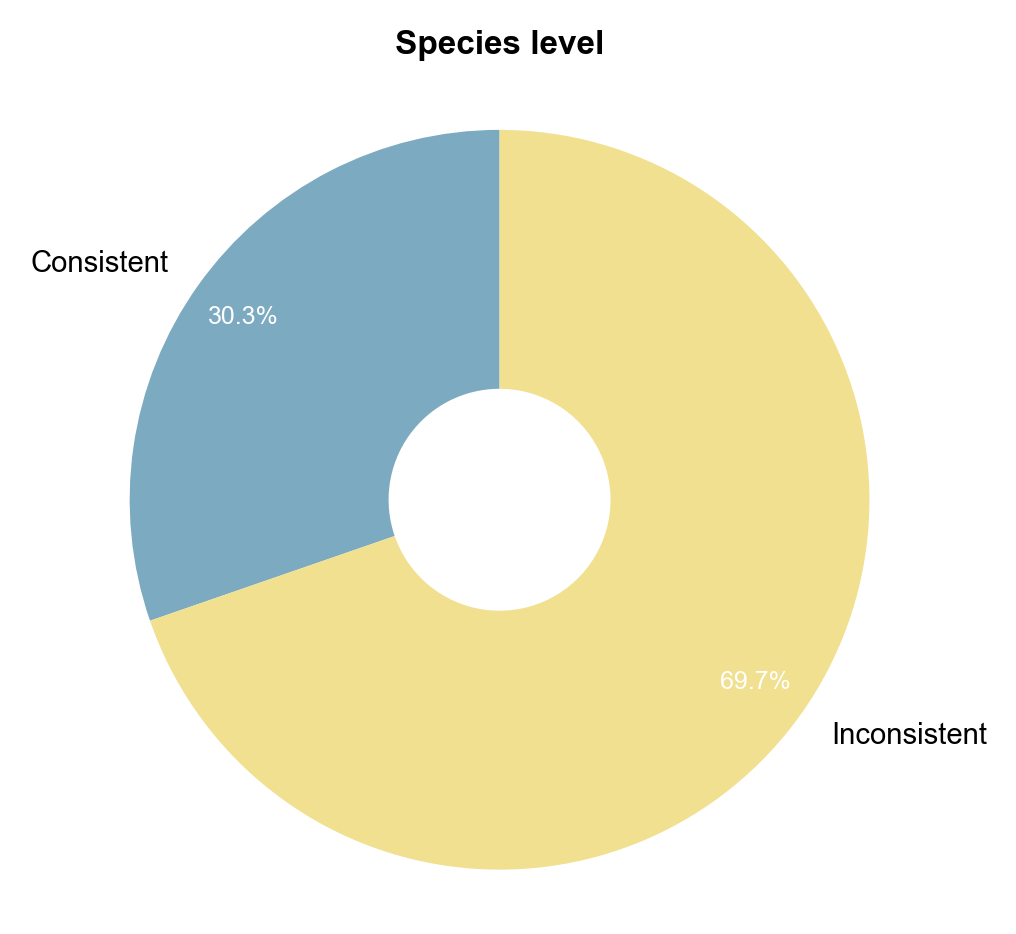

In [174]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data for the Pie Chart ---
labels = ['Consistent', 'Inconsistent']
# Example data: 80% Consistent, 20% Inconsistent
sizes = [common, inconsist] 

# --- NATURE Journal Style Configuration ---
# Set font to a sans-serif type, preferably Arial or Helvetica
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
# Set font size for labels
plt.rcParams['font.size'] = 7
# Ensure fonts are embedded correctly in PDF output
plt.rcParams['pdf.fonttype'] = 42

# Recommended color palette (Wong colorblind-safe)
# From: Wong, B. Points of view: Colour blindness. Nature Methods 8, 441 (2011).
colors = ['#7cabc1', '#f0e08f']  # Blue and Vermillion

# --- Create the Pie Chart ---
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=300) # Corresponds to a single column width of ~89mm

wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'width': 0.7}, # Creates a donut-style chart for a modern look
    startangle=90,
    pctdistance=0.85 # Position of the percentage text inside the wedges
)

# --- Customize Text Properties ---
# Set the color of the labels and percentages to be easily readable
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(6) # Slightly smaller font for percentages if needed

# --- Final Touches ---
ax.set_title('Species level', fontsize=8, weight='bold', pad=10)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# --- Save the Figure ---
# Save in a vector format like PDF for publication
plt.savefig('pie_chart_species.pdf', bbox_inches='tight')

# Display the plot
plt.show()

In [171]:
common = 0
inconsist = 0
for key in crispr2genus.keys():
    if key in df2genus:
        if crispr2genus[key] == df2genus[key]:
            common += 1
        else:
            inconsist += 1
print(f"Common genus: {common}, Inconsistent genus: {inconsist}")

Common genus: 950, Inconsistent genus: 766


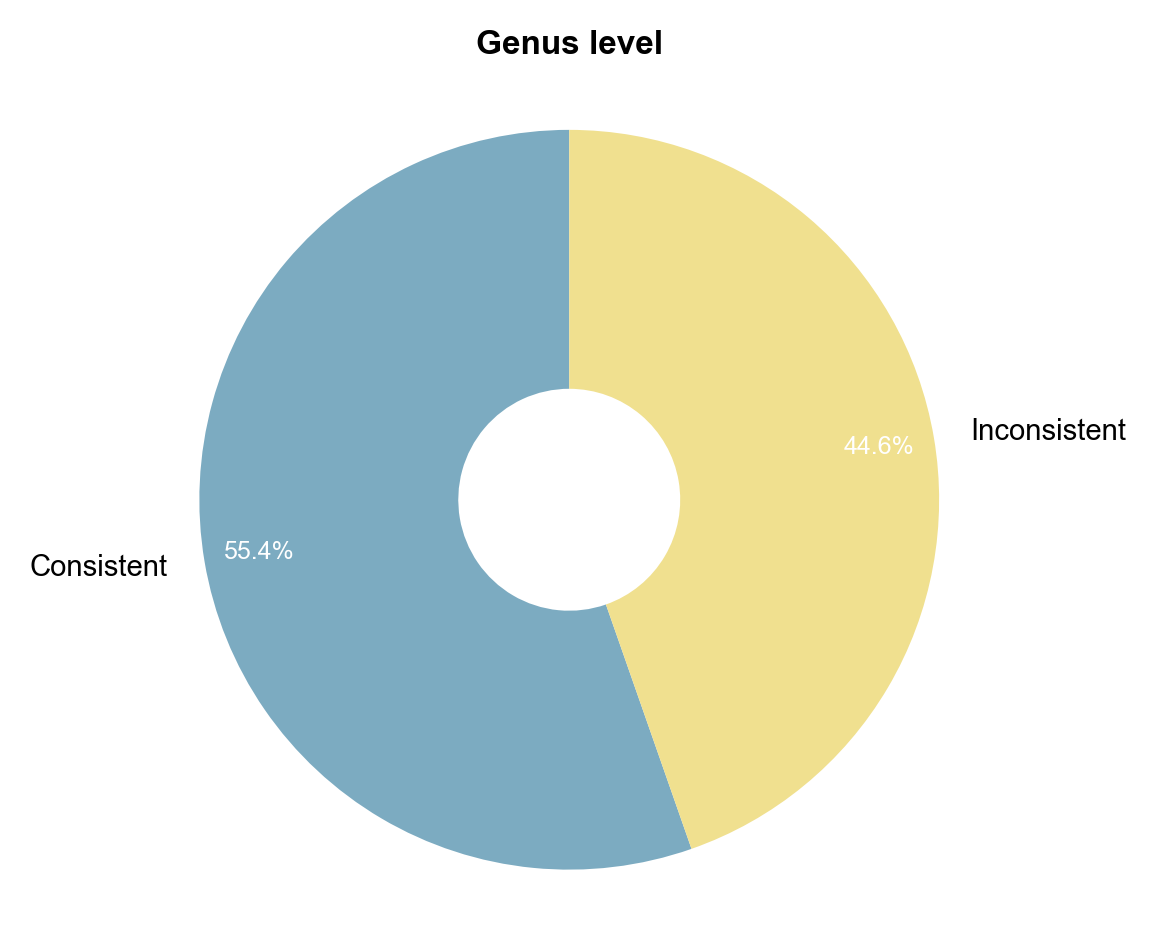

In [172]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data for the Pie Chart ---
labels = ['Consistent', 'Inconsistent']
# Example data: 80% Consistent, 20% Inconsistent
sizes = [common, inconsist] 

# --- NATURE Journal Style Configuration ---
# Set font to a sans-serif type, preferably Arial or Helvetica
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
# Set font size for labels
plt.rcParams['font.size'] = 7
# Ensure fonts are embedded correctly in PDF output
plt.rcParams['pdf.fonttype'] = 42

# Recommended color palette (Wong colorblind-safe)
# From: Wong, B. Points of view: Colour blindness. Nature Methods 8, 441 (2011).
colors = ['#7cabc1', '#f0e08f']  # Blue and Vermillion

# --- Create the Pie Chart ---
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=300) # Corresponds to a single column width of ~89mm

wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'width': 0.7}, # Creates a donut-style chart for a modern look
    startangle=90,
    pctdistance=0.85 # Position of the percentage text inside the wedges
)

# --- Customize Text Properties ---
# Set the color of the labels and percentages to be easily readable
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(6) # Slightly smaller font for percentages if needed

# --- Final Touches ---
ax.set_title('Genus level', fontsize=8, weight='bold', pad=10)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# --- Save the Figure ---
# Save in a vector format like PDF for publication
plt.savefig('pie_chart_genus.pdf', bbox_inches='tight')

# Display the plot
plt.show()

In [168]:
common = 0
inconsist = 0
for key in crispr2family.keys():
    if key in df2family:
        if crispr2family[key] == df2family[key]:
            common += 1
        else:
            inconsist += 1
print(f"Common family: {common}, Inconsistent family: {inconsist}")

Common family: 1205, Inconsistent family: 511


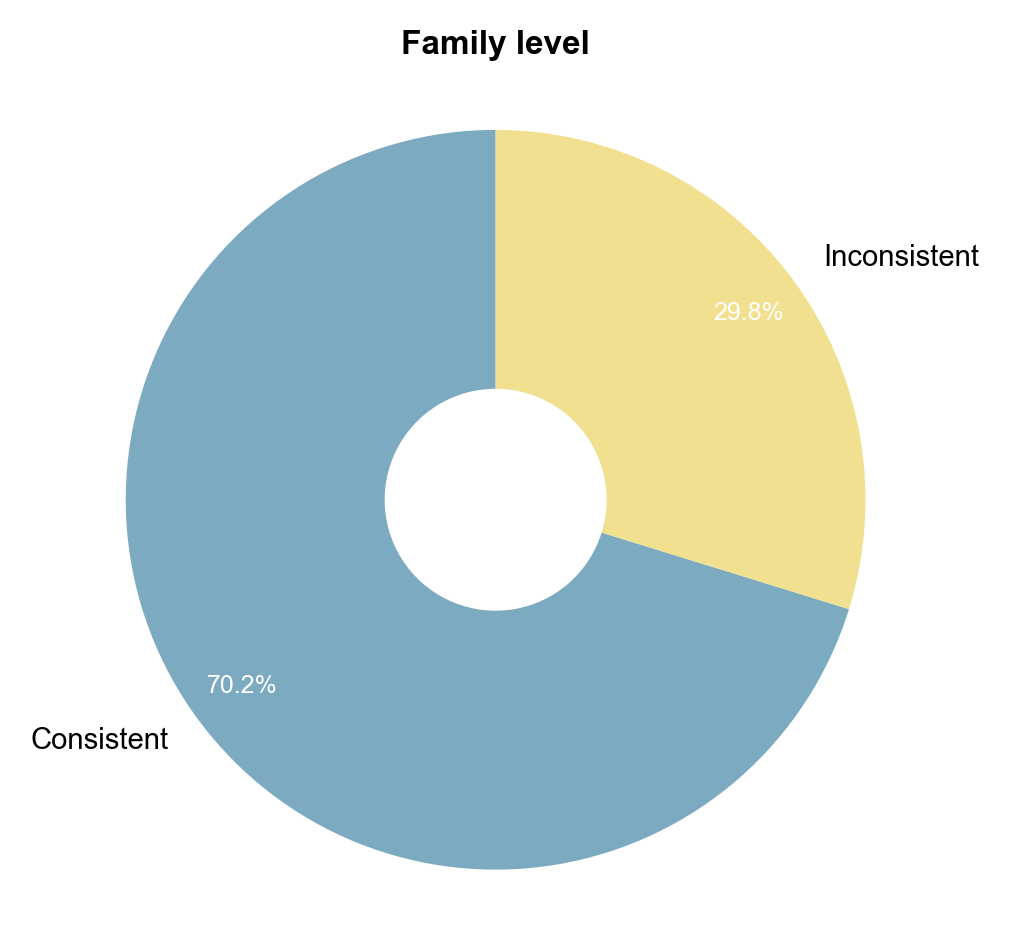

In [170]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data for the Pie Chart ---
labels = ['Consistent', 'Inconsistent']
# Example data: 80% Consistent, 20% Inconsistent
sizes = [common, inconsist] 

# --- NATURE Journal Style Configuration ---
# Set font to a sans-serif type, preferably Arial or Helvetica
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
# Set font size for labels
plt.rcParams['font.size'] = 7
# Ensure fonts are embedded correctly in PDF output
plt.rcParams['pdf.fonttype'] = 42

# Recommended color palette (Wong colorblind-safe)
# From: Wong, B. Points of view: Colour blindness. Nature Methods 8, 441 (2011).
colors = ['#7cabc1', '#f0e08f']  # Blue and Vermillion

# --- Create the Pie Chart ---
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=300) # Corresponds to a single column width of ~89mm

wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%',
    colors=colors,
    wedgeprops={'width': 0.7}, # Creates a donut-style chart for a modern look
    startangle=90,
    pctdistance=0.85 # Position of the percentage text inside the wedges
)

# --- Customize Text Properties ---
# Set the color of the labels and percentages to be easily readable
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(6) # Slightly smaller font for percentages if needed

# --- Final Touches ---
ax.set_title('Family level', fontsize=8, weight='bold', pad=10)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal')  

# --- Save the Figure ---
# Save in a vector format like PDF for publication
plt.savefig('pie_chart_family.pdf', bbox_inches='tight')

# Display the plot
plt.show()

In [220]:
crispr_select = crispr[crispr['cov'] >= 98]
crispr_select = crispr_select[crispr_select['pident'] >= 98]
crispr_select.drop_duplicates(subset=['qseqid'], inplace=True)

In [221]:
df_select = df[df['length'] >= 700]
df_select = df_select[df_select['pident'] >= 100]
df_select.drop_duplicates(subset=['qseqid'], inplace=True)

In [ ]:
crispr2species = {key: value for key, value in zip(crispr_remain['qseqid'], crispr_remain['sspecies'])}
crispr2genus = {key: value for key, value in zip(crispr_remain['qseqid'], crispr_remain['sgenus'])}
crispr2family = {key: value for key, value in zip(crispr_remain['qseqid'], crispr_remain['sfamily'])}
df2species = {key: value for key, value in zip(df_remain['qseqid'], df_remain['sspecies'])}
df2genus = {key: value for key, value in zip(df_remain['qseqid'], df_remain['sgenus'])}
df2family = {key: value for key, value in zip(df_remain['qseqid'], df_remain['sfamily'])}